# Book Recommendation System Pretraining

In this phase, we'll create the components needed for our recommendation system. Nothing fancy, though. Our recommendation system is query based, meaning that it will create a recommendation based on a one single query.

For example, I want to see what book is similar to book A. So I will search for book A on our system, and it will output a collection of what our system thinks is similar to book A.

We'll be using another unsupervised method in this case. Book synopsis that were mined from Google Books API will be extracted into its embeddings using our Double-Stack BERT. After that, we will cluster these embeddings and we'll get the most similar books by comparing one embedding againts the other embeddings in the same cluster using cosine similarity.
So in this pretraining phase, we'll get:
1. The book dataset with each respective assigned cluster id (GoogleBooksAPIDataset_withCluster.csv)
2. The book embeddings (book_embeddings.npy)
3. The book cluster codebook (bookCodebook.npy)

And here's how the process will look like during this pretraining.

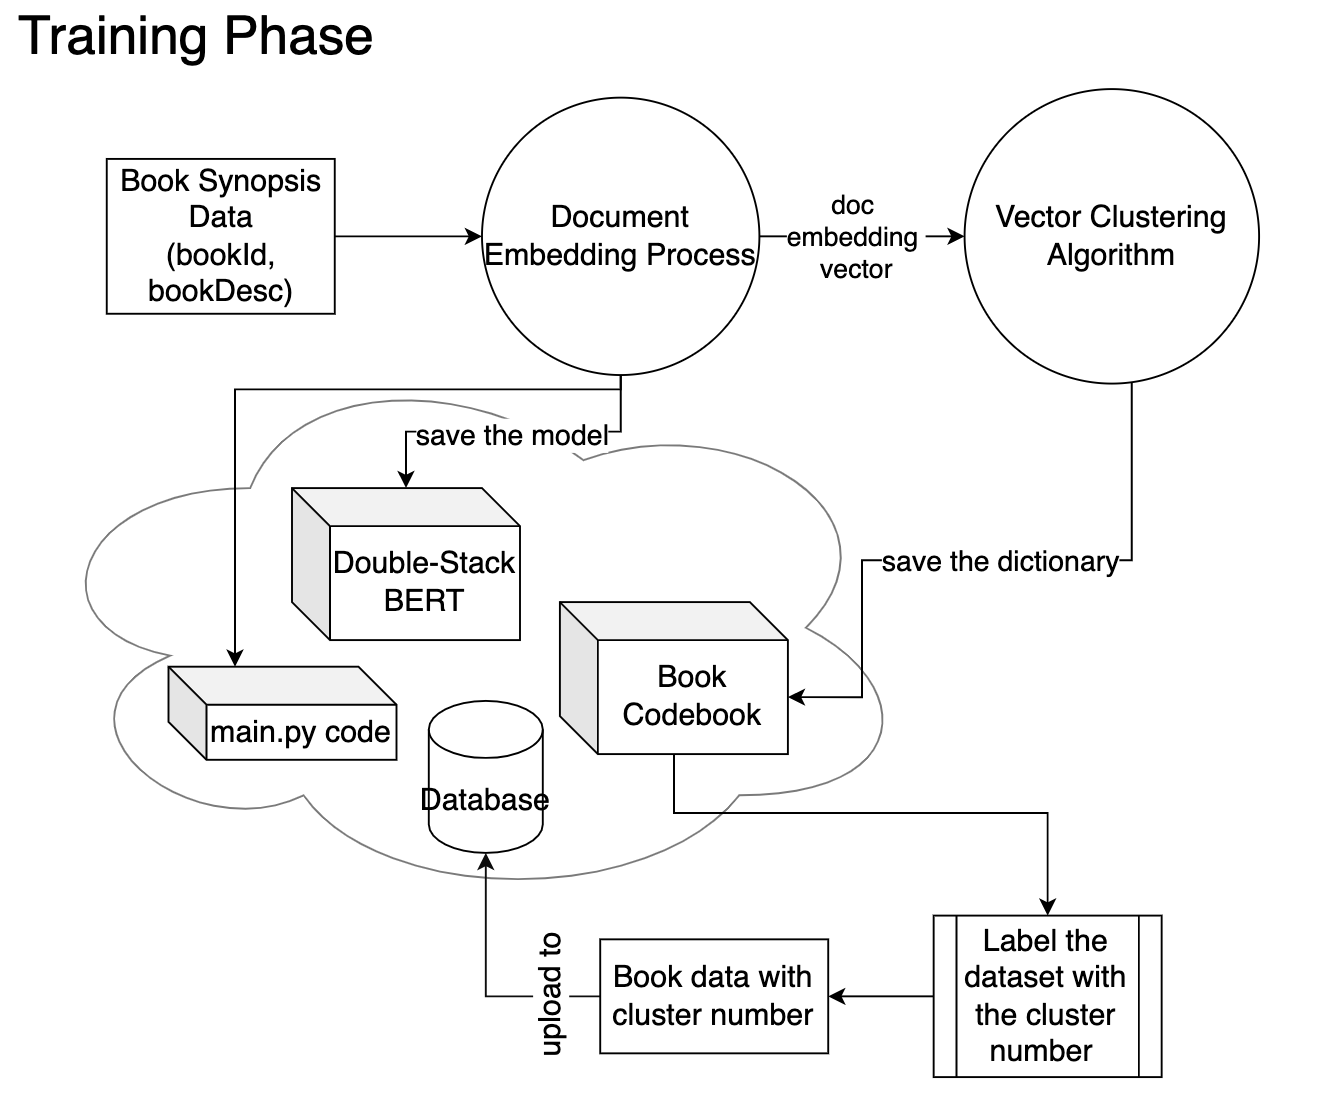

In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
from tqdm.auto import tqdm
import re
from scipy.cluster.vq import *
import torch
import torch.nn as nn
import torch.optim as optim
import math
import json
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM, RobertaModel
from transformers import AdamW

## Loading Data

This dataset has 22,332 books that were mined from Google Play Books API.

In [2]:
dataset = pd.read_csv('GoogleBookAPIDataset.csv')

In [3]:
dataset.describe(include="all")

,Unnamed: 0,Unnamed: 0.1,id,title,desc,authors,categories,averageRating,maturityRating,publishedDate,pageCount
count,22332.000000,22332.000000,22332,22332,22332,22332,22332,22332.000000,22332,22332,22332.000000
unique,NaN,NaN,22332,17622,21726,9815,1187,NaN,2,4942,NaN
top,NaN,NaN,L2EQuwEACAAJ,The Lord of the Rings,When high school student Light Yagami finds th...,['Mercedes Lackey'],['Fiction'],NaN,NOT_MATURE,2006,NaN
freq,NaN,NaN,1,20,9,89,8683,NaN,22125,413,NaN
mean,14514.895665,14514.895665,NaN,NaN,NaN,NaN,NaN,3.884717,NaN,NaN,372.261105
std,8576.627735,8576.627735,NaN,NaN,NaN,NaN,NaN,0.764628,NaN,NaN,1184.606992
min,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000
25%,7008.750000,7008.750000,NaN,NaN,NaN,NaN,NaN,3.500000,NaN,NaN,224.000000
50%,14509.500000,14509.500000,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,320.000000
75%,21960.250000,21960.250000,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,NaN,432.000000


### Example data point

In [4]:
dataset.loc[:0]

,Unnamed: 0,Unnamed: 0.1,id,title,desc,authors,categories,averageRating,maturityRating,publishedDate,pageCount
0,0,0,L2EQuwEACAAJ,Harry Potter and the Half-Blood Prince,"As Harry enters his sixth year at Hogwarts, a ...",['J. K. Rowling'],['England'],4.5,NOT_MATURE,2005,672


## Getting Book Embeddings using Double-Stack BERT

In [5]:
class DoubleStackBERT:
    def __init__(self, tokenizer_source): 
        self.model = RobertaModel.from_pretrained('doublestackbert')
        self.codebook = np.load(tokenizer_source+'/codebook.npy')
        with open(tokenizer_source+'/vocabs.json') as json_file:
            self.__vocabs = json.load(json_file)
        self.sentenceTransformer = SentenceTransformer('all-mpnet-base-v2')
        self.bos_token = self.cls_token = '<s>'
        self.eos_token = self.sep_token = '</s>'
        self.unk_token = '<unk>'
        self.pad_token = '<pad>'
        self.mask_token = '<mask>'
        self.mask_token_id = self.__vocabs['<mask>']

        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        # and move our model over to the selected device
        self.model.to(self.device)
        
    def getVocabSize(self):
        return len(self.__vocabs)
  
    # splitting text into sentences
    # receives a string as parameter
    # returns an array of string(s)
    # library dependencies: re
    def __splitTextToSentences(self,text):
        try:
            arrayOfSentences = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)
        except:
            arrayOfSentences = [""]
        return arrayOfSentences

    # Turns an array of raw text into each of it sentences embedding
    # receives a pretrained Sentence-BERT model and the intended dataset
    # returns 2D array. Each index contains a list of embedded strings
    # library dependencies: sentence_transformers
    # local function dependencies: splitTextToSentences  
    def __getSentencesEmbedding(self, dataset):
        # splitting eaxh text of the dataset into a list of sentences using previously made function
        array = []
        if type(dataset) == str: # if single query
            array.append(dataset)
        else: # if multiple queries
            array = dataset

        sentences_dataset = [self.__splitTextToSentences(text) for text in array]
        dataset_embeddings = []
        for i in range(len(sentences_dataset)):
            embeddings = self.sentenceTransformer.encode(sentences_dataset[i])
            dataset_embeddings.append(embeddings)

        return dataset_embeddings
  
    # Parameter: max_length, padding='max_length', truncation)
    def tokenize(self, list_of_docs, max_length= -1, padding = True, truncation = True): 
        docs_tokens = [] 
        doc_embeddings = self.__getSentencesEmbedding(list_of_docs)
        for doc in doc_embeddings:
            sentences_cluster_ids = vq(doc,self.codebook)
            sentences_token_ids = []
            attention_mask = []
            for cluster_id in sentences_cluster_ids[0]: 
                sentences_token_ids.append(self.__vocabs[str(cluster_id)])

            if truncation and max_length != -1 :
                if len(sentences_token_ids) + 2 > max_length:
                    sentences_token_ids = sentences_token_ids[:(max_length-2)]
                    padding = False

            input_ids = [self.__vocabs['<s>']] + sentences_token_ids + [self.__vocabs['</s>']]
            attention_mask.extend([1] * len(input_ids))

            if padding:
                padding_len = max_length - len(input_ids)
                input_ids.extend([self.__vocabs['<pad>']] * padding_len)
                attention_mask.extend([0] * padding_len)

            docs_tokens.append({'input_ids':input_ids, 'attention_mask':attention_mask})

        return docs_tokens

    def getTensors(self,dataset,max_length= -1, padding = True, truncation = True):
        tensors = []
        if type(dataset) is str:
            dataset = [dataset]
        for d in dataset:
            t = torch.tensor([self.tokenize(d,max_length,padding,truncation)[0]['input_ids']])
            output = self.model(t).pooler_output.cpu().detach().numpy()
            tensors.append(output.reshape((output.shape[1])))
        return tensors

    def getEmbeddings(self,dataset, max_length= -1, padding = True, truncation = True):
        if type(dataset) == str:
            dataset = [dataset]
        embeddings = self.sentenceTransformer.encode(dataset)
        tensors = self.getTensors(dataset,max_length,padding,truncation)
        return np.concatenate((embeddings, tensors), axis=1)

In [7]:
model = DoubleStackBERT('doublestackbert_tokenizer')

Some weights of the model checkpoint at doublestackbert were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at doublestackbert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
book_embeddings = model.getEmbeddings(dataset['desc'])
# saving
np.save("book_embeddings.npy",book_embeddings)

## Clustering the book embeddings

In [ ]:
from scipy.cluster.vq import *
# using 200 cluster
bookCodebook,_ = kmeans(book_embeddings, 200, 20)

In [ ]:
np.save("bookCodebook.npy",bookCodebook)

## Getting each book's cluster

In [12]:
bookCodebook = np.load('bookCodebook.npy')

In [13]:
cluster, _ = vq(book_embeddings,bookCodebook)

In [14]:
dataset['cluster'] = cluster

In [15]:
dataset['cluster']

0        134
1         32
2        134
3        134
4         19
        ... 
22327    118
22328    102
22329     85
22330    185
22331      2
Name: cluster, Length: 22332, dtype: int32

In [16]:
# Saving the new dataset
dataset.to_csv('GoogleBooksAPIDataset_withCluster.csv', index = False)